In [1]:
import os
os.environ['KAGGLE_USERNAME'] = ''  # Your Kaggle username
os.environ['KAGGLE_KEY'] = ''  # Your Kaggle API key
os.environ['URN'] = '6644818'  # Your URN: submissions without a URN will not count#

#!kaggle competitions download -c uos-com2028-21-22-cw()
#!unzip uos-com2028-21-22-cw.zip

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, utils
from tensorflow.keras.utils import image_dataset_from_directory, to_categorical
from tensorflow.data import AUTOTUNE
import tensorflow_addons as tfa

import random
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass

2022-04-11 15:32:17.411718: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 15:32:17.463585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 15:32:17.463741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Read the data

In [3]:
color_mode = 'grayscale'
image_size = (28, 28)
image_shape = (*image_size, 1)
batch_size = 32

num_classes = 8

In [4]:
#read all labels
train_labels_dp = pd.read_csv('train.csv')
train_labels = tf.constant(train_labels_dp.loc[:, 'Cell type'].values)

2022-04-11 15:32:17.511864: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-11 15:32:17.512853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 15:32:17.513091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 15:32:17.513224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [5]:
#based on https://www.tensorflow.org/tutorials/load_data/images

def pathToLabel(path):
  path = tf.strings.regex_replace(path, "./train/", "")
  path = tf.strings.regex_replace(path, ".jpg", "")
  return train_labels[tf.strings.to_number(path, out_type=tf.int32)]

def decode_image(img):
  # channels were reduced to 1 since image is grayscale
  img = tf.io.decode_jpeg(img, channels=1)

  return tf.image.resize(img, image_size)

def process_path(path, addPath=False):
  label = pathToLabel(path)

  img = tf.io.read_file(path)
  img = decode_image(img)

  if addPath:
    return img, label, path
  else:
    return img, label

def configure_for_performance(ds: tf.data.Dataset) -> tf.data.Dataset:
  #ds = ds.cache()
  ds = ds.shuffle(buffer_size= 1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(AUTOTUNE)
  return ds

def prepare_dataset(ds: tf.data.Dataset) -> tf.data.Dataset:
  ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)
  ds = configure_for_performance(ds)
  return ds
  

In [6]:
seed = random.randint(0, 10000)

print("seed: %d" % seed)

# Read all the files from the direcotry
list_ds = tf.data.Dataset.list_files(str('./train/*'), shuffle=False)

image_count = len(list_ds)

list_ds = list_ds.shuffle(image_count, seed=seed)

val_size = int(image_count * 0.333)

train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

train_ds = prepare_dataset(train_ds)
val_ds   = prepare_dataset(val_ds)


seed: 8681


In [1]:
# Show some images
# image_batch, label_batch  = next(iter(train_ds))

# plt.figure(figsize=image_size)
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].numpy().astype("uint8"), cmap='gray')

#   label = label_batch[i]
#   path = ""#str(path_batch[i].numpy())

#   plt.title(str(label.numpy()) + " " + path)
#   plt.axis("off")


Read the testing set

In [8]:
test_ds = image_dataset_from_directory(
  './test', 
  labels=None, 
  shuffle=False,
  color_mode=color_mode,
  batch_size=1,
  image_size=image_size)

Found 50000 files belonging to 1 classes.


Create a model

In [12]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=image_shape),
    layers.RandomRotation(2),
    layers.RandomContrast(0.4),
  ]
)

model = keras.Sequential()
model.add(layers.Rescaling(1.0/255, input_shape=image_shape))
model.add(layers.Flatten())
model.add(layers.Dense(240, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(120, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(60, activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(
  loss=keras.losses.SparseCategoricalCrossentropy(),
  optimizer=tfa.optimizers.AdamW(weight_decay=1e-4),
  metrics=['accuracy']
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 240)               188400    
                                                                 
 dropout_2 (Dropout)         (None, 240)               0         
                                                                 
 dense_4 (Dense)             (None, 120)               28920     
                                                                 
 dropout_3 (Dropout)         (None, 120)               0         
                                                                 
 dense_5 (Dense)             (None, 60)               

In [13]:
# https://www.tensorflow.org/tutorials/keras/regression
def plot_loss(history, val=True, color="b", save=False):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['accuracy'], label='accuracy')
    if val:
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend()
        plt.grid(True)
    if save:
        plt.savefig('./fig.png')
    else:
        plt.show()

Epoch 1/70
3127/3127 [==============================] - 10s 3ms/step - loss: 1.5439 - accuracy: 0.4483 - val_loss: 1.4489 - val_accuracy: 0.4739
Epoch 2/70
3127/3127 [==============================] - 10s 3ms/step - loss: 1.4628 - accuracy: 0.4708 - val_loss: 1.4163 - val_accuracy: 0.4849
Epoch 3/70
3127/3127 [==============================] - 10s 3ms/step - loss: 1.4382 - accuracy: 0.4779 - val_loss: 1.4042 - val_accuracy: 0.4869
Epoch 4/70
3127/3127 [==============================] - 10s 3ms/step - loss: 1.4295 - accuracy: 0.4798 - val_loss: 1.4032 - val_accuracy: 0.4850
Epoch 5/70
3127/3127 [==============================] - 10s 3ms/step - loss: 1.4244 - accuracy: 0.4841 - val_loss: 1.4130 - val_accuracy: 0.4799
Epoch 6/70
3127/3127 [==============================] - 10s 3ms/step - loss: 1.4196 - accuracy: 0.4839 - val_loss: 1.3757 - val_accuracy: 0.4922
Epoch 7/70
3127/3127 [==============================] - 10s 3ms/step - loss: 1.4157 - accuracy: 0.4852 - val_loss: 1.3798 - val_ac

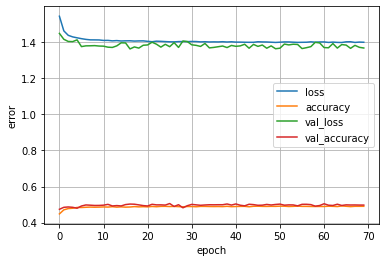

In [14]:
his = model.fit(train_ds, validation_data=val_ds, epochs=70)

plot_loss(his, save=True)

# This will send notifications on supported systems
# !notify-send -i "$(pwd)/fig.png" "AI: finished training"

In [14]:
predictions = [np.argmax(x) for x in model.predict(test_ds)]
predictions[:10]

[6,
 6,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 3,
 4,
 3,
 6,
 0,
 0,
 6,
 6,
 2,
 7,
 7,
 3,
 4,
 3,
 2,
 2,
 0,
 5,
 0,
 0,
 6,
 3,
 0,
 6,
 0,
 0,
 6,
 6,
 3,
 7,
 6,
 4,
 7,
 0,
 0,
 6,
 0,
 0,
 5,
 6,
 0,
 2,
 0,
 6,
 6,
 6,
 0,
 6,
 6,
 3,
 6,
 6,
 3,
 6,
 0,
 0,
 0,
 0,
 2,
 0,
 5,
 0,
 0,
 0,
 6,
 6,
 0,
 2,
 3,
 0,
 6,
 0,
 6,
 2,
 6,
 0,
 2,
 4,
 0,
 6,
 2,
 1,
 0,
 6,
 6,
 6,
 0,
 0,
 4,
 2,
 0,
 6,
 0,
 6,
 6,
 6,
 1,
 6,
 6,
 0,
 0,
 0,
 0,
 0,
 7,
 6,
 4,
 3,
 0,
 6,
 0,
 0,
 6,
 6,
 7,
 0,
 4,
 6,
 7,
 3,
 0,
 7,
 7,
 6,
 0,
 3,
 6,
 3,
 6,
 7,
 0,
 6,
 0,
 0,
 0,
 0,
 3,
 2,
 6,
 3,
 6,
 6,
 0,
 0,
 0,
 7,
 0,
 0,
 6,
 6,
 3,
 6,
 0,
 0,
 6,
 0,
 3,
 0,
 6,
 0,
 3,
 0,
 0,
 4,
 0,
 6,
 0,
 0,
 6,
 0,
 0,
 6,
 3,
 2,
 3,
 6,
 0,
 0,
 6,
 0,
 6,
 0,
 6,
 0,
 6,
 3,
 3,
 7,
 3,
 5,
 5,
 0,
 7,
 7,
 0,
 4,
 0,
 0,
 0,
 0,
 7,
 0,
 0,
 7,
 0,
 7,
 6,
 3,
 3,
 0,
 0,
 0,
 0,
 7,
 6,
 3,
 6,
 3,
 3,
 7,
 6,
 6,
 0,
 7,
 0,
 7,
 6,
 0,
 2,
 0,
 0,
 1,
 0,
 4,
 6,
 4,
 0,
 6,


In [15]:
from pandas import DataFrame
DataFrame(data={'Cell type': predictions}).to_csv('predictions.csv', index_label='Id')

In [16]:
!kaggle competitions submit -m $URN -c uos-com2028-21-22-cw -f predictions.csv

100%|█████████████████████████████████████████| 380k/380k [00:02<00:00, 178kB/s]
Successfully submitted to COM2028 21/22 CW